In [1]:
## import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline


In [2]:
df = pd.read_csv('/kaggle/input/heart-disease-dataset/heart_statlog_cleveland_hungary_final.csv')
df.head()

,age,sex,chest pain type,resting bp s,cholesterol,fasting blood sugar,resting ecg,max heart rate,exercise angina,oldpeak,ST slope,target
0,40,1,2,140,289,0,0,172,0,0.0,1,0
1,49,0,3,160,180,0,0,156,0,1.0,2,1
2,37,1,2,130,283,0,1,98,0,0.0,1,0
3,48,0,4,138,214,0,0,108,1,1.5,2,1
4,54,1,3,150,195,0,0,122,0,0.0,1,0


# Data Cleaning
## Check the datatypes of the dataset.

In [3]:
df.dtypes

age                      int64
sex                      int64
chest pain type          int64
resting bp s             int64
cholesterol              int64
fasting blood sugar      int64
resting ecg              int64
max heart rate           int64
exercise angina          int64
oldpeak                float64
ST slope                 int64
target                   int64
dtype: object

## We must convert some columns into categorical.

In [4]:
df['chest pain type'] = df['chest pain type'].astype('object')
df['resting ecg'] = df['resting ecg'].astype('object')
df['ST slope'] = df['ST slope'].astype('object')

## Check for missing values or duplicates.

In [5]:
duplicates = df.duplicated()

# Check for duplicated values
if duplicates.empty:
  print("We have duplicates values\n")
else:
  print("We don't have duplicates values.\n")

# check for missing values
if df.isna().any().any():
  print("There are missing values in the dataset.")
else:
  print("There are no missing values in the dataset.")

We don't have duplicates values.

There are no missing values in the dataset.


## Create numerical and categorical list

In [6]:
categorical_columns = df.select_dtypes(include=['object', 'category']).columns.to_list()
numerical_columns = df.select_dtypes(exclude=['object']).columns.to_list()

# Explanatory Data Analysis (EDA)
## Return some statistics for the dataset.
### We can see some anomalies in the cholesterol and max heart rate. So we have to check that

In [7]:
df.describe()

,age,sex,resting bp s,cholesterol,fasting blood sugar,max heart rate,exercise angina,oldpeak,target
count,1190.000000,1190.000000,1190.000000,1190.000000,1190.000000,1190.000000,1190.000000,1190.000000,1190.000000
mean,53.720168,0.763866,132.153782,210.363866,0.213445,139.732773,0.387395,0.922773,0.528571
std,9.358203,0.424884,18.368823,101.420489,0.409912,25.517636,0.487360,1.086337,0.499393
min,28.000000,0.000000,0.000000,0.000000,0.000000,60.000000,0.000000,-2.600000,0.000000
25%,47.000000,1.000000,120.000000,188.000000,0.000000,121.000000,0.000000,0.000000,0.000000
50%,54.000000,1.000000,130.000000,229.000000,0.000000,140.500000,0.000000,0.600000,1.000000
75%,60.000000,1.000000,140.000000,269.750000,0.000000,160.000000,1.000000,1.600000,1.000000
max,77.000000,1.000000,200.000000,603.000000,1.000000,202.000000,1.000000,6.200000,1.000000


## Visualize the paiplot.

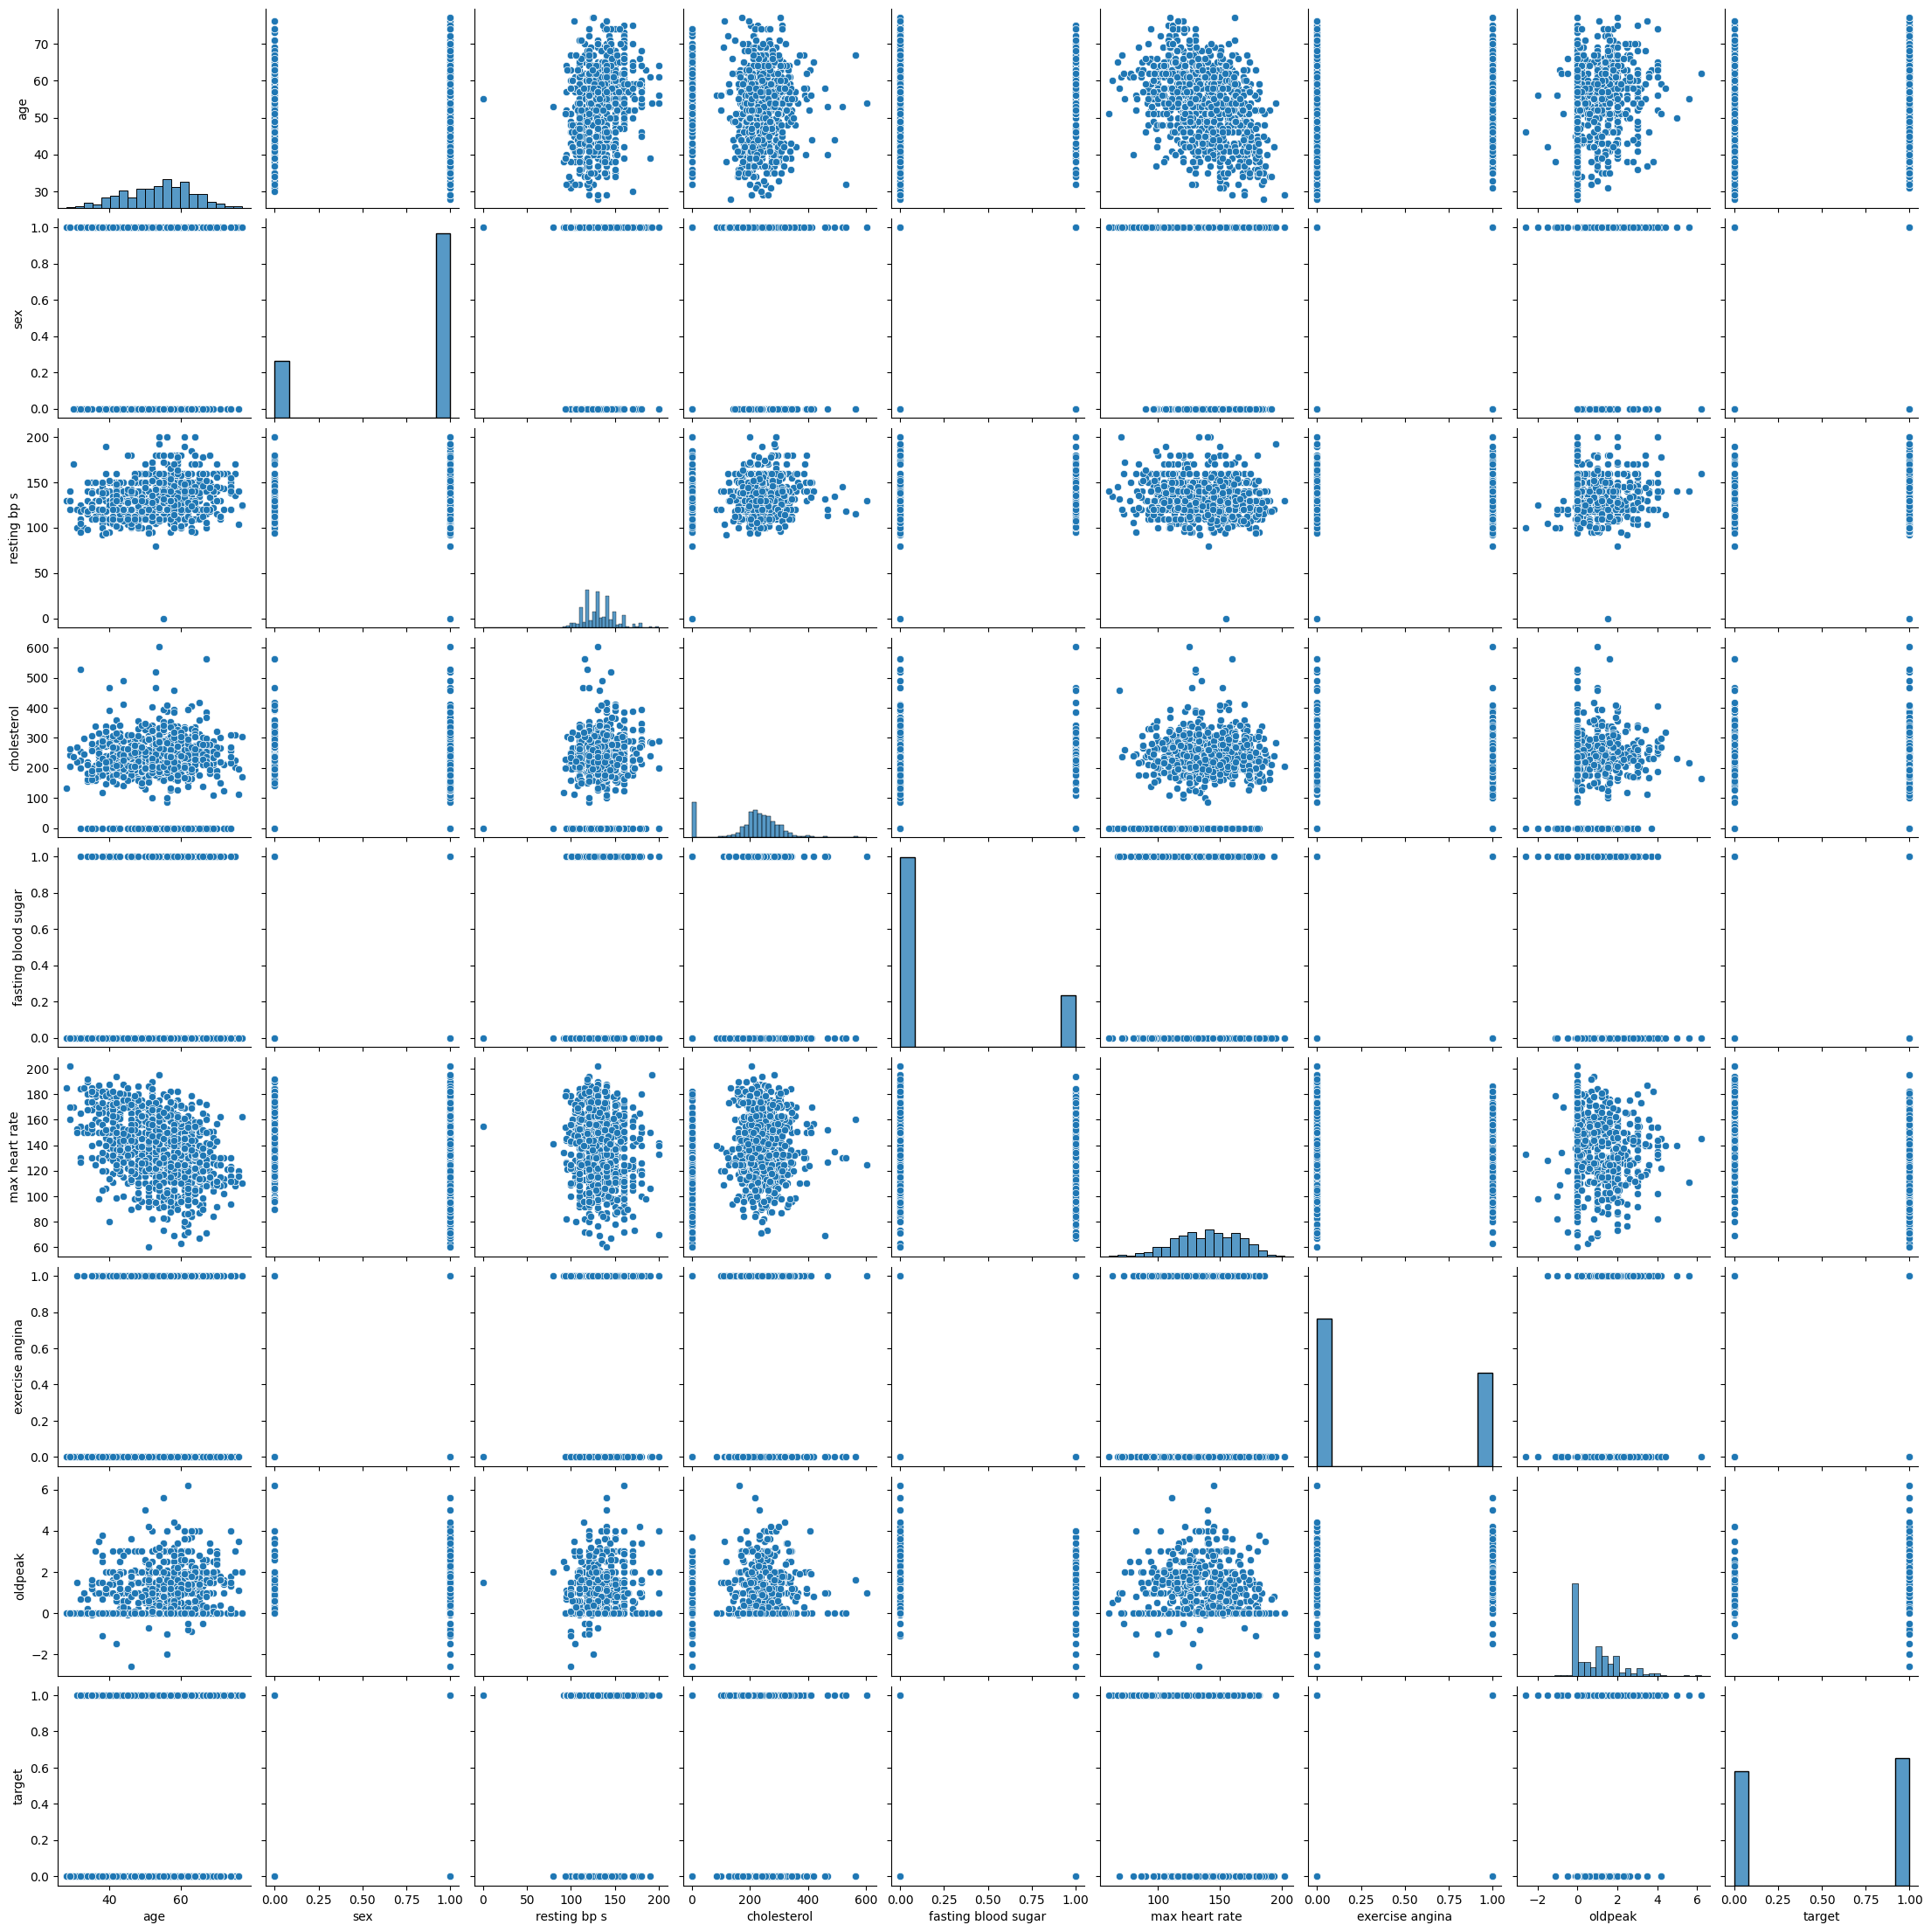

In [8]:
sns.pairplot(df[numerical_columns])

## Let's focus on the Cholesterol.


<Axes: xlabel='cholesterol', ylabel='Count'>

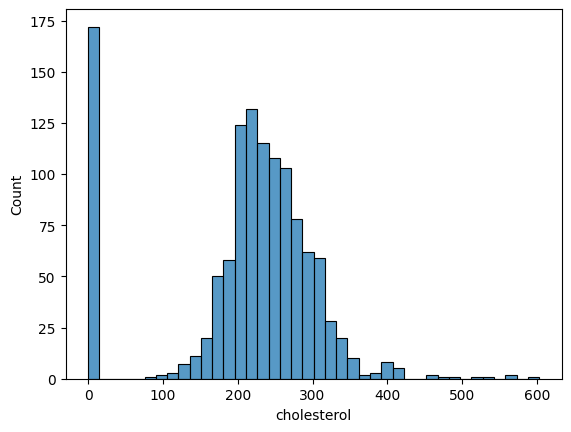

In [9]:
sns.histplot(df['cholesterol'], kde=False)


## Let's use boxplot for the cholesterol column


{'whiskers': [<matplotlib.lines.Line2D at 0x7da4b95c0310>,
 'caps': [<matplotlib.lines.Line2D at 0x7da4b95c0850>,
 'boxes': [<matplotlib.lines.Line2D at 0x7da4b95c0070>],
 'medians': [<matplotlib.lines.Line2D at 0x7da4b95c0d90>],
 'fliers': [<matplotlib.lines.Line2D at 0x7da4b95c1030>],
 'means': []}

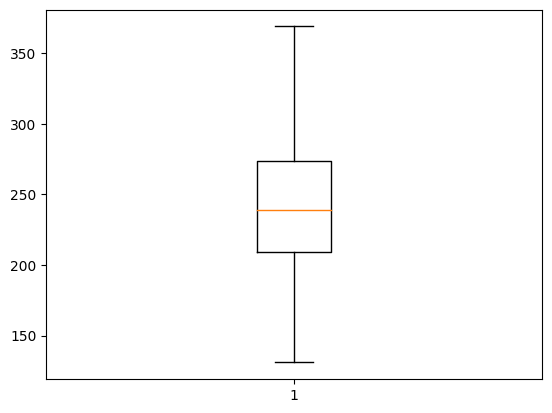

In [10]:
# Drop cholesterol which is zero, bigger than 380 or below 130
new_df = df[(df['cholesterol']<=380) & (df['cholesterol']>=130)]
plt.boxplot(new_df['cholesterol'])

## Let's focus on heart rate.

<Axes: xlabel='max heart rate', ylabel='Count'>

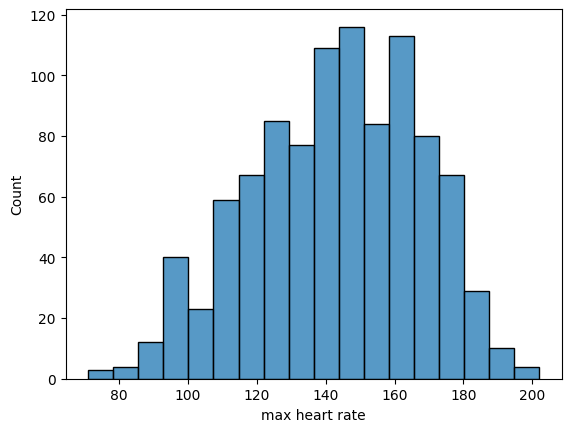

In [11]:
sns.histplot(new_df['max heart rate'], kde=False)


{'whiskers': [<matplotlib.lines.Line2D at 0x7da4b94aec50>,
 'caps': [<matplotlib.lines.Line2D at 0x7da4b94af190>,
 'boxes': [<matplotlib.lines.Line2D at 0x7da4b94ae9b0>],
 'medians': [<matplotlib.lines.Line2D at 0x7da4b94af5b0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7da4b94af850>],
 'means': []}

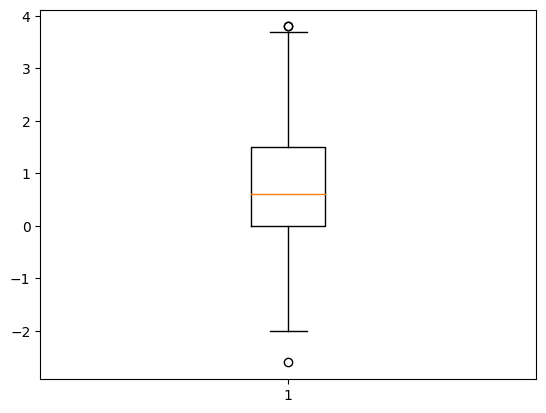

In [12]:
new_df = df[df['oldpeak']<4]
plt.boxplot(new_df['oldpeak'])

## Correlation 

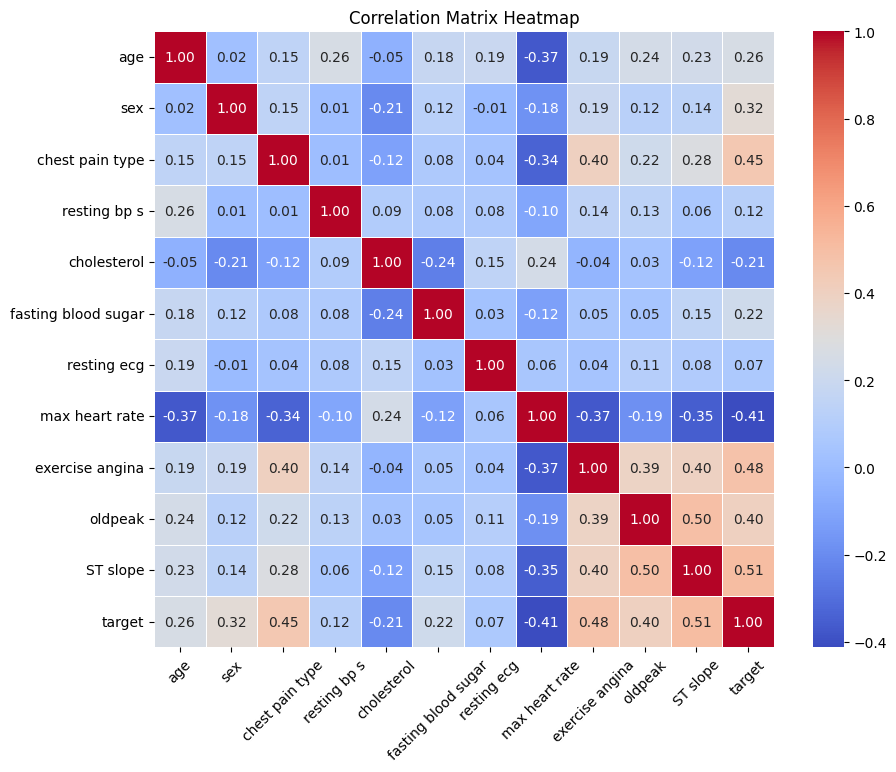

In [13]:
# Compute the correlation matrix
corr_matrix = new_df.corr()

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)

# Rotate the tick labels for better visibility
plt.xticks(rotation=45)
plt.yticks(rotation=0)

# Add title
plt.title('Correlation Matrix Heatmap')

# Show plot
plt.show()


# Prepare for modeling 

In [14]:
#Independent and dependent variable
X = df.iloc[:,:-1]
y = df.iloc[:,-1]

numerical_columns.remove('target')

X_train, X_test, y_train, y_test = train_test_split(X,y,train_size = 0.8, random_state = 42)

numerical_pipeline = Pipeline([
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('onehot', OneHotEncoder())
])

# Combine the pipelines using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, numerical_columns),
        ('cat', categorical_pipeline, categorical_columns)
    ]
)

# Apply preprocessing to the Train and Test sets
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)


In [15]:
print("X_train_preprocessed shape:", X_train_preprocessed.shape)
print("X_test_preprocessed shape:", X_test_preprocessed.shape)

X_train_preprocessed shape: (952, 19)
X_test_preprocessed shape: (238, 19)


Accuracy: 0.9537815126050421


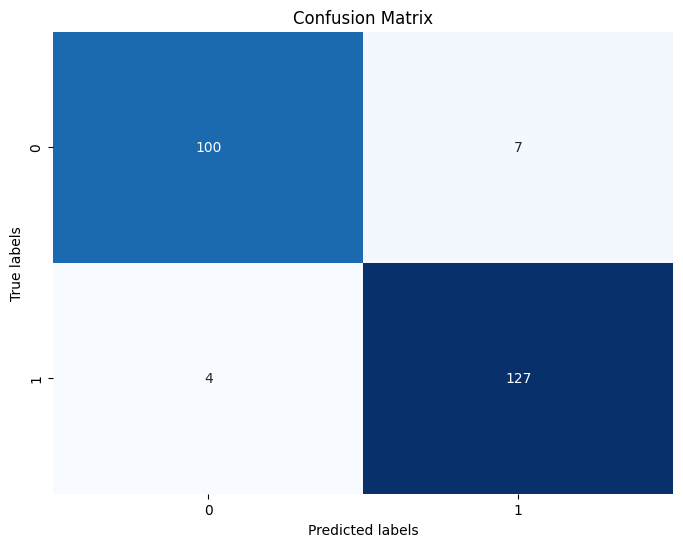

In [16]:
# Initialize the Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier on the training data
rf_classifier.fit(X_train_preprocessed, y_train)

# Predict the labels of the test set
y_pred = rf_classifier.predict(X_test_preprocessed)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix as heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()